In [101]:
# Object detection

In [102]:
# ───────────────────────────────────  
# 1. Install Ultralytics YOLO-v8 + deps  
# ───────────────────────────────────  
#%pip install -q ultralytics opencv-python-headless pyyaml  
  
import cv2, yaml, zipfile, shutil, os  
from pathlib import Path  
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
from ultralytics import YOLO  
from sklearn.model_selection import train_test_split

In [103]:
# ───────────────────────────────────  
# 2. Create project skeleton  
# ───────────────────────────────────  
ROOT       = Path().resolve()  
data_dir   = ROOT / 'data'  
images_dir = data_dir / 'images'  
labels_dir = data_dir / 'labels'  
for p in (images_dir, labels_dir):  
    p.mkdir(parents=True, exist_ok=True)

# If you already uploaded images.zip, unzip here (skip otherwise)  
zip_path = ROOT / 'images.zip'  
if zip_path.exists():  
    with zipfile.ZipFile(zip_path) as z:  
        z.extractall(images_dir)  
    print('Images extracted to', images_dir) 

Images extracted to /Users/muralibalusa/PG_AIML/Python/vehicle_object_detection_project/data/images


In [104]:
# ───────────────────────────────────  
# 3. Read CSV and peek at it  
# ───────────────────────────────────  
import io

csv_path = labels_dir / 'labels.csv'      # adjust if stored elsewhere  
#df = pd.read_csv(io.StringIO(csv_path), dtype={'filename': str}, header=None,  
 #                names=['filename','class_name','x_min','y_min','x_max','y_max'])  
df = pd.read_csv(csv_path, dtype={'filename': str}, header=None,  
                 names=['filename','class_name','x_min','y_min','x_max','y_max'])
display(df.head())          # preview  
print('Total rows:', len(df))  

/var/folders/7y/bflqb96959vgktr703vv6mcm0000gp/T/ipykernel_8239/3421266688.py:9: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path, dtype={'filename': str}, header=None,


,filename,class_name,x_min,y_min,x_max,y_max
0,00000000,pickup_truck,213.0,34.0,255.0,50.0
1,00000000,car,194.0,78.0,273.0,122.0
2,00000000,car,155.0,27.0,183.0,35.0
3,00000000,articulated_truck,43.0,25.0,109.0,55.0
4,00000000,car,106.0,32.0,124.0,45.0


Total rows: 351549


In [105]:
display(df.columns)

Index(['filename', 'class_name', 'x_min', 'y_min', 'x_max', 'y_max'], dtype='object')

In [106]:
first_filename = df['filename'].iloc[0]

print(first_filename)

00000000


In [107]:
# Convert to a list first
first_10_list = df['filename'].head(10).to_list()
print("As a Python list:")
print(first_10_list)

As a Python list:
['00000000', '00000000', '00000000', '00000000', '00000000', '00000001', '00000001', '00000001', '00000001', '00000001']


In [108]:
images_dir = images_dir / "Images"
print(f"images_dir: {images_dir}")

images_dir: /Users/muralibalusa/PG_AIML/Python/vehicle_object_detection_project/data/images/Images


In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351549 entries, 0 to 351548
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   filename    17967 non-null  object 
 1   class_name  17967 non-null  object 
 2   x_min       17967 non-null  float64
 3   y_min       17967 non-null  float64
 4   x_max       17967 non-null  float64
 5   y_max       17967 non-null  float64
dtypes: float64(4), object(2)
memory usage: 16.1+ MB


In [110]:
# ───────────────────────────────────  
# 4. Convert every row into YOLO txt  
# ───────────────────────────────────  

# Build class ↔ id mapping  
classnames = sorted(df['class_name'].dropna().unique()) #By adding .dropna(), you ensure that unique() and sorted() only operate on a clean list of string class names, resolving the TypeError.
class2id   = {c:i for i,c in enumerate(classnames)}  
print('Classes -> id\n', class2id)  

# --- This section is now correct ---
# Create the labels directory
labels_dir = data_dir / 'labels'
os.makedirs(labels_dir, exist_ok=True)
  
def ensure_ext(name):  
    stem = Path(name).stem  
    # assume images are .jpg or .png – adjust if needed  
    for ext in ('.jpg','.png','.jpeg'):  
        cand = images_dir / (stem + ext)  
        if cand.exists(): return cand.name  
    return stem + '.jpg'   # fall-back  

# Ensure the 'filename' column is string type before mapping
df['filename'] = df['filename'].astype(str)
df['filename'] = df['filename'].map(ensure_ext)  
  
for img_name, group in df.groupby('filename'):  
    img_path = images_dir / img_name  
    if not img_path.exists():  
        print('Warning – image missing:', img_name)  
        continue  
    # This is great - you are getting the real image dimensions
    h, w = cv2.imread(str(img_path)).shape[:2]  
  
    lines = []  
    for _,row in group.iterrows():  
        x_min,y_min,x_max,y_max = row[['x_min','y_min','x_max','y_max']]  
        x_c = (x_min+x_max)/2 / w  
        y_c = (y_min+y_max)/2 / h  
        bw  = (x_max-x_min)/w  
        bh  = (y_max-y_min)/h  
        line = f"{class2id[row['class_name']]} {x_c:.6f} {y_c:.6f} {bw:.6f} {bh:.6f}"
        lines.append(line)  
  
    # THE FIX: Changed '\\n' to '\n' to create a proper newline character
    (labels_dir / (Path(img_name).stem + '.txt')).write_text('\n'.join(lines))  
  
print('Label txt files written →', labels_dir)

Classes -> id
 {'articulated_truck': 0, 'bicycle': 1, 'bus': 2, 'car': 3, 'motorcycle': 4, 'motorized_vehicle': 5, 'non-motorized_vehicle': 6, 'pedestrian': 7, 'pickup_truck': 8, 'single_unit_truck': 9, 'work_van': 10}
Warning – image missing: nan.jpg
Label txt files written → /Users/muralibalusa/PG_AIML/Python/vehicle_object_detection_project/data/labels


In [111]:
# ───────────────────────────────────  
# 5. Write dataset.yaml for YOLO-v8  
# ───────────────────────────────────  
#yaml_dict = dict(  
#    path  = str(data_dir.resolve()),  
#    train = 'images/Images',     # we’ll use the same folder for train/val in this demo  
#    val   = 'images/Images',  
#    test  = 'images/Images',  
#    nc    = len(classnames),  
#    names = classnames  
#)  
#yaml_path = data_dir / 'dataset.yaml'  
#yaml.safe_dump(yaml_dict, open(yaml_path,'w'))  
#print('dataset.yaml saved at', yaml_path)  

In [112]:
# --- Diagnostic Cell ---

# Make sure these variables are defined from your previous cells
# data_dir = Path(...) 
# df = pd.read_csv(...) 

# Re-define the source directories exactly as you have them
source_images_dir = data_dir / 'images' / 'Images'
source_labels_dir = data_dir / 'labels'

# Get the VERY FIRST filename from your DataFrame
first_filename = df['filename'].iloc[0]

print(f"DataFrame 'filename' column has: '{first_filename}'")
print("-" * 30)
print(f"Checking for files in this directory: {source_images_dir}")
print("-" * 30)

# Check for the image file with different possible extensions
found_image = False
for ext in ['.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG']:
    # Construct the full path to the potential image file
    test_image_path = source_images_dir / f"{first_filename}{ext}"
    
    print(f"Attempting to find: {test_image_path}")
    
    # Check if this specific path exists
    if os.path.exists(test_image_path):
        print("SUCCESS: Found the image file!")
        found_image = True
        break # Exit the loop once found

if not found_image:
    print("\nFAILURE: Could NOT find the image file for the first entry.")

# Also check the corresponding label file
test_label_path = source_labels_dir / f"{first_filename}.txt"
print("-" * 30)
print(f"Attempting to find label file: {test_label_path}")
if os.path.exists(test_label_path):
    print("SUCCESS: Found the label file.")
else:
    print("FAILURE: Could NOT find the label file.")

DataFrame 'filename' column has: '00000000.jpg'
------------------------------
Checking for files in this directory: /Users/muralibalusa/PG_AIML/Python/vehicle_object_detection_project/data/images/Images
------------------------------
Attempting to find: /Users/muralibalusa/PG_AIML/Python/vehicle_object_detection_project/data/images/Images/00000000.jpg.jpg
Attempting to find: /Users/muralibalusa/PG_AIML/Python/vehicle_object_detection_project/data/images/Images/00000000.jpg.jpeg
Attempting to find: /Users/muralibalusa/PG_AIML/Python/vehicle_object_detection_project/data/images/Images/00000000.jpg.png
Attempting to find: /Users/muralibalusa/PG_AIML/Python/vehicle_object_detection_project/data/images/Images/00000000.jpg.JPG
Attempting to find: /Users/muralibalusa/PG_AIML/Python/vehicle_object_detection_project/data/images/Images/00000000.jpg.JPEG
Attempting to find: /Users/muralibalusa/PG_AIML/Python/vehicle_object_detection_project/data/images/Images/00000000.jpg.PNG

FAILURE: Could NOT

In [113]:
# --- NEW CELL: Create a clean 'basename' column ---

# This command takes the 'filename' column, removes the '.jpg' at the end, 
# and stores the result in a new 'basename' column.
df['basename'] = df['filename'].str.replace(r'\.jpg$', '', regex=True)

# Let's look at the result to confirm it worked
print("DataFrame with the new 'basename' column:")
print(df.head())

DataFrame with the new 'basename' column:
       filename         class_name  x_min  y_min  x_max  y_max  basename
0  00000000.jpg       pickup_truck  213.0   34.0  255.0   50.0  00000000
1  00000000.jpg                car  194.0   78.0  273.0  122.0  00000000
2  00000000.jpg                car  155.0   27.0  183.0   35.0  00000000
3  00000000.jpg  articulated_truck   43.0   25.0  109.0   55.0  00000000
4  00000000.jpg                car  106.0   32.0  124.0   45.0  00000000


In [114]:
# ──────────────────────────────────────────────────────────────────
# 5A. FINAL CORRECTED SCRIPT: Split data into training and validation sets
# ──────────────────────────────────────────────────────────────────
import os
import shutil
from sklearn.model_selection import train_test_split

# --- Define paths ---
# Your confirmed source directory
source_images_dir = data_dir / 'images' / 'Images' 
source_labels_dir = data_dir / 'labels' 

print(f"Source images directory: {source_images_dir}")
print(f"Source labels directory: {source_labels_dir}")

# --- Create train/val directories ---
train_img_dir = data_dir / 'images' / 'train'
val_img_dir   = data_dir / 'images' / 'val'
train_lbl_dir = data_dir / 'labels' / 'train'
val_lbl_dir   = data_dir / 'labels' / 'val'

os.makedirs(train_img_dir, exist_ok=True)
os.makedirs(val_img_dir, exist_ok=True)
os.makedirs(train_lbl_dir, exist_ok=True)
os.makedirs(val_lbl_dir, exist_ok=True)

# --- Get unique image basenames from our NEW 'basename' column ---
image_basenames = df['basename'].unique()

# --- Split the basenames ---
train_basenames, val_basenames = train_test_split(image_basenames, test_size=0.2, random_state=42)

print(f"\nSplitting {len(image_basenames)} unique basenames: {len(train_basenames)} training, {len(val_basenames)} validation.")

# --- Function to copy files using the clean basenames ---
def copy_files(basenames, dest_img_dir, dest_lbl_dir):
    img_copied_count = 0
    lbl_copied_count = 0

    for basename in basenames:
        # Build the source paths correctly
        src_img_path = source_images_dir / f"{basename}.jpg"
        src_lbl_path = source_labels_dir / f"{basename}.txt"

        # --- Copy image file ---
        if os.path.exists(src_img_path):
            shutil.copy(str(src_img_path), str(dest_img_dir))
            img_copied_count += 1
        
        # --- Copy label file ---
        if os.path.exists(src_lbl_path):
            shutil.copy(str(src_lbl_path), str(dest_lbl_dir))
            lbl_copied_count += 1
            
    print(f"Copied {img_copied_count} images to {dest_img_dir}")
    print(f"Copied {lbl_copied_count} labels to {dest_lbl_dir}")

# --- Copy the files ---
print("\n--- Processing Training Files ---")
copy_files(train_basenames, train_img_dir, train_lbl_dir)

print("\n--- Processing Validation Files ---")
copy_files(val_basenames, val_img_dir, val_lbl_dir)

print("\nFinished organizing files.")

Source images directory: /Users/muralibalusa/PG_AIML/Python/vehicle_object_detection_project/data/images/Images
Source labels directory: /Users/muralibalusa/PG_AIML/Python/vehicle_object_detection_project/data/labels

Splitting 5627 unique basenames: 4501 training, 1126 validation.

--- Processing Training Files ---
Copied 4500 images to /Users/muralibalusa/PG_AIML/Python/vehicle_object_detection_project/data/images/train
Copied 4500 labels to /Users/muralibalusa/PG_AIML/Python/vehicle_object_detection_project/data/labels/train

--- Processing Validation Files ---
Copied 1126 images to /Users/muralibalusa/PG_AIML/Python/vehicle_object_detection_project/data/images/val
Copied 1126 labels to /Users/muralibalusa/PG_AIML/Python/vehicle_object_detection_project/data/labels/val

Finished organizing files.


In [115]:
# ──────────────────────────────────────────────────────────────────
# 5B. REVISED: Write dataset.yaml for YOLO-v8
# ──────────────────────────────────────────────────────────────────
# Now create the YAML file pointing to the new, correct directories.
# The paths should be relative to the YAML file's location.

yaml_dict = dict(
    # These paths are relative to the location of dataset.yaml (the 'data' folder)
    train = 'images/train',  
    val   = 'images/val',    
    
    # Number of classes
    nc    = len(classnames),
    
    # Class names in order
    names = classnames  
)  

yaml_path = data_dir / 'dataset.yaml'  
with open(yaml_path, 'w') as f:
    yaml.safe_dump(yaml_dict, f, default_flow_style=False, sort_keys=False)

print('dataset.yaml saved at', yaml_path)
print('\n--- YAML File Content ---')
with open(yaml_path, 'r') as f:
    print(f.read())

dataset.yaml saved at /Users/muralibalusa/PG_AIML/Python/vehicle_object_detection_project/data/dataset.yaml

--- YAML File Content ---
train: images/train
val: images/val
nc: 11
names:
- articulated_truck
- bicycle
- bus
- car
- motorcycle
- motorized_vehicle
- non-motorized_vehicle
- pedestrian
- pickup_truck
- single_unit_truck
- work_van



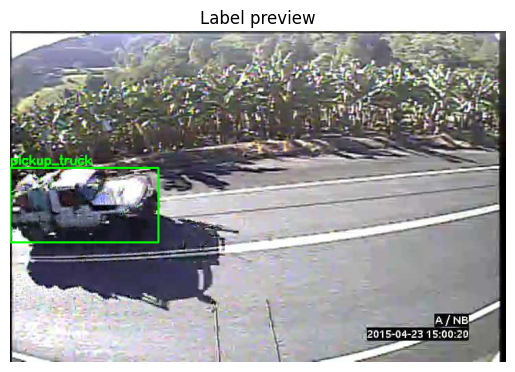

In [116]:
# ───────────────────────────────────  
# 6. Draw first image with its boxes  
# ───────────────────────────────────  

sample_img = next(iter(images_dir.iterdir()))  
img   = cv2.cvtColor(cv2.imread(str(sample_img)), cv2.COLOR_BGR2RGB)  
h,w   = img.shape[:2]  
txt   = labels_dir / (sample_img.stem + '.txt')  
  
for line in txt.read_text().strip().splitlines():  
    cls,x,y,bw,bh = map(float,line.split())  
    x,y,bw,bh = x*w, y*h, bw*w, bh*h  
    x1,y1,x2,y2 = int(x-bw/2),int(y-bh/2),int(x+bw/2),int(y+bh/2)  
    cv2.rectangle(img,(x1,y1),(x2,y2),(0,255,0),2)  
    cv2.putText(img, classnames[int(cls)], (x1, y1-5),  
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)  
  
plt.imshow(img); plt.axis('off'); plt.title('Label preview'); plt.show()  

In [117]:
# Complete YOLO Model Training and Saving Solution

print("=== YOLO MODEL TRAINING & SAVING SOLUTION ===")

# 1. Define model save paths
MODEL_SAVE_DIR = "saved_models"
TRAINED_MODEL_PATH = f"{MODEL_SAVE_DIR}/best_model.pt"
BACKUP_MODEL_PATH = f"{MODEL_SAVE_DIR}/last_model.pt"

# Create directory for saved models
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

print(f"✓ Created model save directory: {MODEL_SAVE_DIR}/")

# 2. Function to check if trained model exists
def model_exists():
    return os.path.exists(TRAINED_MODEL_PATH)

# 3. Function to save model after training
def save_trained_model(results, model_name="best_model"):
    """Save the trained model to a permanent location"""
    try:
        # Get the path to the best model from training results
        best_model_path = results.save_dir / "weights" / "best.pt"
        last_model_path = results.save_dir / "weights" / "last.pt"
        
        # Copy to our permanent location
        if os.path.exists(best_model_path):
            shutil.copy2(best_model_path, TRAINED_MODEL_PATH)
            print(f"✓ Best model saved to: {TRAINED_MODEL_PATH}")
        
        if os.path.exists(last_model_path):
            shutil.copy2(last_model_path, BACKUP_MODEL_PATH)
            print(f"✓ Last model saved to: {BACKUP_MODEL_PATH}")
            
        return True
    except Exception as e:
        print(f"❌ Error saving model: {e}")
        return False

# 4. Function to load existing model
def load_trained_model():
    """Load previously trained model"""
    if model_exists():
        model = YOLO(TRAINED_MODEL_PATH)
        print(f"✓ Loaded existing trained model from: {TRAINED_MODEL_PATH}")
        return model
    else:
        print("❌ No trained model found")
        return None

print("✓ Model management functions defined")
print(f"✓ Trained model will be saved to: {TRAINED_MODEL_PATH}")
print(f"✓ Backup model will be saved to: {BACKUP_MODEL_PATH}")

=== YOLO MODEL TRAINING & SAVING SOLUTION ===
✓ Created model save directory: saved_models/
✓ Model management functions defined
✓ Trained model will be saved to: saved_models/best_model.pt
✓ Backup model will be saved to: saved_models/last_model.pt


In [118]:
# Now create the complete training workflow with model saving
print("=== COMPLETE TRAINING WORKFLOW WITH MODEL SAVING ===")

# Complete workflow function
def train_or_load_model(yaml_path, force_retrain=True):
    """
    Train a new model or load existing one
    
    Args:
        yaml_path: Path to your dataset YAML file
        force_retrain: If True, train even if model exists
    
    Returns:
        Trained YOLO model
    """
    
    # Check if we already have a trained model
    if model_exists() and not force_retrain:
        print("🔄 Found existing trained model, loading...")
        return load_trained_model()
    
    # Train new model
    print("🚀 Training new YOLO model...")
    
    # Initialize model
    model = YOLO('yolov8n.pt')
    
    # Train the model
    results = model.train(
        data=str(yaml_path),
        imgsz=640,
        epochs=10,  # You can adjust this
        batch=4,
        name='csv2yolo_demo_epochs',
        save=True,  # Ensure saving is enabled
        save_period=1  # Save every epoch
    )
    
    # Save the trained model to our permanent location
    if save_trained_model(results):
        print("✅ Model training completed and saved successfully!")
    else:
        print("⚠️ Model trained but saving failed")
    
    # Return the trained model
    return model

print("✓ Complete training workflow function created")

# Usage examples
print("\
=== USAGE EXAMPLES ===")
print("# To train or load model:")
print("model = train_or_load_model('path/to/your/dataset.yaml')")
print("")
print("# To force retrain even if model exists:")
print("model = train_or_load_model('path/to/your/dataset.yaml', force_retrain=True)")
print("")
print("# To just load existing model:")
print("model = load_trained_model()")
print("")
print("# To check if model exists:")
print("if model_exists():")
print("    print('Model ready to use!')")
print("else:")
print("    print('Need to train model first')")

=== COMPLETE TRAINING WORKFLOW WITH MODEL SAVING ===
✓ Complete training workflow function created
=== USAGE EXAMPLES ===
# To train or load model:
model = train_or_load_model('path/to/your/dataset.yaml')

# To force retrain even if model exists:
model = train_or_load_model('path/to/your/dataset.yaml', force_retrain=True)

# To just load existing model:
model = load_trained_model()

# To check if model exists:
if model_exists():
    print('Model ready to use!')
else:
    print('Need to train model first')


In [119]:
# To train or load model:
model = train_or_load_model(yaml_path)

🚀 Training new YOLO model...
New https://pypi.org/project/ultralytics/8.3.167 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.161 🚀 Python-3.9.6 torch-2.2.2 CPU (Intel Core(TM) i7-8850H 2.60GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/Users/muralibalusa/PG_AIML/Python/vehicle_object_detection_project/data/dataset.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, m

train: Scanning /Users/muralibalusa/PG_AIML/Python/vehicle_object_detection_project/data/labels/train.cache... 4500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4500/4500 [00:00<?, ?it/s]

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 83.0±55.4 MB/s, size: 25.7 KB)



val: Scanning /Users/muralibalusa/PG_AIML/Python/vehicle_object_detection_project/data/labels/val.cache... 1126 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1126/1126 [00:00<?, ?it/s]


Plotting labels to runs/detect/csv2yolo_demo_epochs2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/csv2yolo_demo_epochs2
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G      1.258      2.578      1.094         16        640: 100%|██████████| 1125/1125 [44:08<00:00,  2.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 141/141 [02:50<00:00,  1.21s/it]


                   all       1126       3550      0.435      0.299      0.243      0.165

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G      1.167      1.793      1.052         16        640: 100%|██████████| 1125/1125 [45:54<00:00,  2.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 141/141 [02:36<00:00,  1.11s/it]


                   all       1126       3550      0.458      0.335      0.327      0.218

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G      1.137       1.47      1.044          7        640: 100%|██████████| 1125/1125 [46:29<00:00,  2.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 141/141 [02:41<00:00,  1.15s/it]


                   all       1126       3550      0.464      0.366      0.361      0.241

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      1.106      1.286      1.029         15        640: 100%|██████████| 1125/1125 [44:43<00:00,  2.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 141/141 [02:41<00:00,  1.14s/it]

                   all       1126       3550      0.443      0.444      0.383      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G       1.07      1.147      1.013          6        640: 100%|██████████| 1125/1125 [44:44<00:00,  2.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 141/141 [02:49<00:00,  1.20s/it]

                   all       1126       3550      0.512      0.462      0.444      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G      1.035      1.053     0.9947          5        640: 100%|██████████| 1125/1125 [40:55<00:00,  2.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 141/141 [01:55<00:00,  1.22it/s]

                   all       1126       3550      0.558      0.473      0.466      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G      1.004     0.9816     0.9832         13        640: 100%|██████████| 1125/1125 [34:15<00:00,  1.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 141/141 [01:55<00:00,  1.22it/s]

                   all       1126       3550      0.539      0.459      0.504      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G     0.9816      0.924     0.9728         11        640: 100%|██████████| 1125/1125 [34:10<00:00,  1.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 141/141 [01:54<00:00,  1.23it/s]

                   all       1126       3550      0.619      0.508       0.52      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G     0.9545      0.869     0.9621         27        640: 100%|██████████| 1125/1125 [34:11<00:00,  1.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 141/141 [01:54<00:00,  1.23it/s]

                   all       1126       3550      0.631      0.488      0.514      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G     0.9405     0.8258     0.9566          7        640: 100%|██████████| 1125/1125 [34:21<00:00,  1.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 141/141 [02:05<00:00,  1.12it/s]

                   all       1126       3550      0.557      0.518      0.535       0.39



10 epochs completed in 7.124 hours.
Optimizer stripped from runs/detect/csv2yolo_demo_epochs2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/csv2yolo_demo_epochs2/weights/best.pt, 6.2MB

Validating runs/detect/csv2yolo_demo_epochs2/weights/best.pt...
Ultralytics 8.3.161 🚀 Python-3.9.6 torch-2.2.2 CPU (Intel Core(TM) i7-8850H 2.60GHz)
Model summary (fused): 72 layers, 3,007,793 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 141/141 [01:38<00:00,  1.43it/s]


                   all       1126       3550      0.558      0.519      0.535       0.39
     articulated_truck         81         93      0.609      0.699      0.704      0.513
               bicycle         25         36      0.545      0.633      0.612      0.413
                   bus         95        101      0.773      0.874      0.899      0.795
                   car        926       2377      0.787      0.878      0.895      0.653
            motorcycle         19         23      0.681      0.348      0.445      0.277
     motorized_vehicle        213        262      0.506      0.237       0.31      0.182
 non-motorized_vehicle         21         21          0          0      0.024     0.0117
            pedestrian         39         58      0.526       0.46      0.384      0.189
          pickup_truck        313        408      0.725      0.762      0.819      0.651
     single_unit_truck         65         74      0.485      0.392      0.356      0.264
              work_va

In [120]:
# To just load existing model:
model = load_trained_model()

if model_exists():
    print('Model ready to use!')
else:
    print('Need to train model first')

✓ Loaded existing trained model from: saved_models/best_model.pt
Model ready to use!



image 1/1 /Users/muralibalusa/PG_AIML/Python/vehicle_object_detection_project/data/images/Images/00003135.jpg: 448x640 1 car, 1 pickup_truck, 71.6ms
Speed: 3.1ms preprocess, 71.6ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


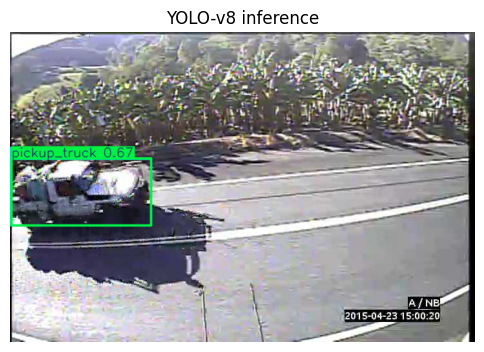

In [121]:
# ───────────────────────────────────  
# 8. Run inference, plot result  
# ───────────────────────────────────  
best_pt = Path('runs/detect/csv2yolo_demo_epochs/weights/best.pt')  
if not best_pt.exists():              # if training was skipped  
    best_pt = 'yolov8n.pt'  
  
detector = YOLO(best_pt)  
pred     = detector.predict(source=str(sample_img), save=False, conf=0.1)[0]  
  
# Convert Ultralytics Result to array for plotting  
img_pred = pred.plot()      # BGR with annotations  
plt.figure(figsize=(6,6))  
plt.imshow(cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB))  
plt.axis('off'); plt.title('YOLO-v8 inference'); plt.show() 

In [122]:
# Complete guide for testing your YOLO model with custom vehicle images
print("=== TESTING YOUR YOLO MODEL WITH CUSTOM VEHICLE IMAGES ===")

# 1. Load your trained model
best_pt = Path('runs/detect/csv2yolo_demo_epochs/weights/best.pt')
if not best_pt.exists():
    best_pt = 'yolov8n.pt'
    print("⚠️ Using pre-trained YOLOv8n model (training weights not found)")
else:
    print("✅ Using your trained model weights")

detector = YOLO(best_pt)
print(f"✓ Model loaded from: {best_pt}")

# 2. Function to test single image
def test_single_image(image_path, confidence_threshold=0.1, save_result=True):
    """
    Test your model on a single image
    
    Args:
        image_path: Path to your vehicle image
        confidence_threshold: Minimum confidence for detections (0.1 = 10%)
        save_result: Whether to save the annotated image
    """
    
    # Check if image exists
    if not Path(image_path).exists():
        print(f"❌ Image not found: {image_path}")
        return None
    
    print(f"🔍 Testing image: {image_path}")
    
    # Run inference
    results = detector.predict(
        source=str(image_path), 
        save=save_result, 
        conf=confidence_threshold,
        show_labels=True,
        show_conf=True
    )[0]
    
    # Get annotated image
    img_pred = results.plot()
    
    # Display results
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f'YOLO Detection Results - {Path(image_path).name}')
    plt.show()
    
    # Print detection details
    if len(results.boxes) > 0:
        print(f"✅ Found {len(results.boxes)} detections:")
        for i, box in enumerate(results.boxes):
            class_id = int(box.cls[0])
            confidence = float(box.conf[0])
            class_name = results.names[class_id]
            print(f"  {i+1}. {class_name}: {confidence:.2%} confidence")
    else:
        print("❌ No detections found")
    
    return results

print("✓ Single image testing function created")

=== TESTING YOUR YOLO MODEL WITH CUSTOM VEHICLE IMAGES ===
✅ Using your trained model weights
✓ Model loaded from: runs/detect/csv2yolo_demo_epochs/weights/best.pt
✓ Single image testing function created


🔍 Testing image: /Users/muralibalusa/PG_AIML/Python/vehicle_object_detection_project/data/images/testimages/00005626.jpg

image 1/1 /Users/muralibalusa/PG_AIML/Python/vehicle_object_detection_project/data/images/testimages/00005626.jpg: 448x640 1 articulated_truck, 1 bus, 3 cars, 74.7ms
Speed: 3.1ms preprocess, 74.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict3


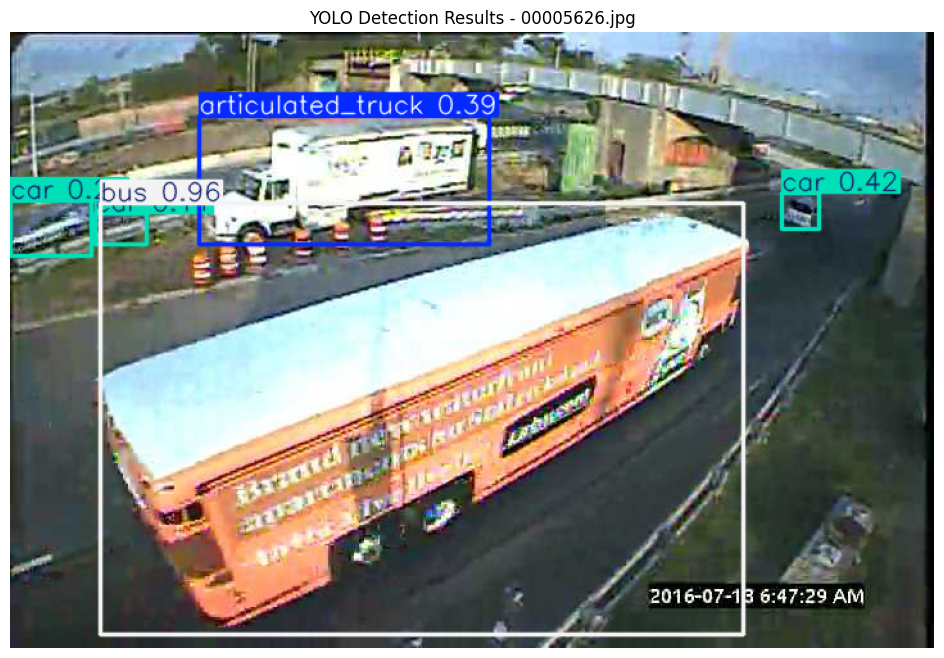

✅ Found 5 detections:
  1. bus: 95.84% confidence
  2. car: 41.99% confidence
  3. articulated_truck: 38.80% confidence
  4. car: 20.72% confidence
  5. car: 11.18% confidence


ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'articulated_truck', 1: 'bicycle', 2: 'bus', 3: 'car', 4: 'motorcycle', 5: 'motorized_vehicle', 6: 'non-motorized_vehicle', 7: 'pedestrian', 8: 'pickup_truck', 9: 'single_unit_truck', 10: 'work_van'}
obb: None
orig_img: array([[[ 7, 22, 31],
        [ 5, 20, 29],
        [ 4, 17, 25],
        ...,
        [ 9, 10,  0],
        [ 7,  9,  3],
        [ 0,  4,  0]],

       [[ 7, 22, 31],
        [ 7, 23, 30],
        [ 9, 22, 30],
        ...,
        [ 8,  9,  0],
        [ 6,  8,  2],
        [ 0,  3,  0]],

       [[12, 25, 33],
        [13, 26, 34],
        [17, 28, 36],
        ...,
        [ 6,  7,  0],
        [ 4,  6,  0],
        [ 0,  2,  0]],

       ...,

       [[54, 37, 40],
        [54, 37, 40],
        [52, 38, 40],
        ...,
        [ 0,  4,  3],
        [ 6, 11, 10],
        [11, 16, 15]],

       [[54, 37, 40],
        [54

In [123]:
test_single_image_path = data_dir / 'images' / 'testimages' / '00005626.jpg'
test_single_image(test_single_image_path)